# Minimax Linkage 

There is no minimax linkage implemented in ```scipy.cluster.hierarchy``` as of Feb 2021. There is a standalone package [pyprotoclust](https://github.com/andgoldschmidt/pyprotoclust), possibly the only python package available for minimax linkage, but a simple pip install doesn't always work. 

Below is a brute force implementation. 

There is an nearest neighbor chain algorithm which is used in scipy for complete linkage. Minimax linkage can be implemented the same way too. 

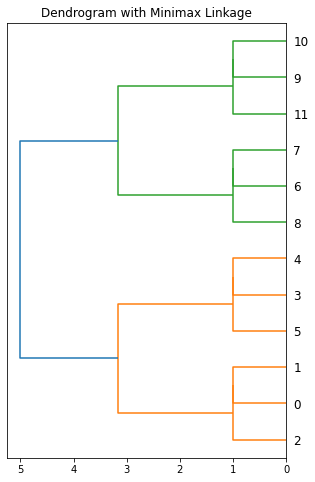

CPU times: user 821 ms, sys: 330 ms, total: 1.15 s
Wall time: 1.16 s


In [3]:
%%time

import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from pandas import DataFrame
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

def minimax_linkage(dist):
    n = int((np.sqrt(8*len(dist) + 1) + 1)/2)
    
    def d(i, j): return dist[n*i+j-((i+2)*(i+1))//2] if i<j else (0 if i==j else d(j, i))
    def r(i, G): return max(d(i, j) for j in G)
    
    Z = []
    clusters = {i: set([i]) for i in range(n)}
    for i in range(n-1):
        min_d = math.inf
        for (idxG, G), (idxH, H) in combinations(clusters.items(), 2):
            dminimax = min(r(x, G|H) for x in G|H)
            if dminimax < min_d:
                min_d = dminimax
                to_merge = [idxG, idxH, dminimax, len(G|H)]
        Z.append(to_merge)
        idxG, idxH, _, _ = to_merge
        clusters[n+i] = clusters.pop(idxG) | clusters.pop(idxH)
        
    return Z

X = [[0, 0], [0, 1], [1, 0], [0, 4], [0, 3], [1, 4], [4, 0], [3, 0], [4, 1], [4, 4], [3, 4], [4, 3]]
Z = minimax_linkage(pdist(X))
# Z = hierarchy.complete(pdist(X))

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
hierarchy.dendrogram(Z, ax=ax, orientation='left')
ax.set(title='Dendrogram with Minimax Linkage')
plt.show()